# Fitting a gaussian model to an image

In astronomy, it is common to deal with images of the night sky with stars and galaxies seen as point sources. These point sources, denoted as point spread function (PSF) are usually approximated with a 2D gaussian. We will attempt to model our sample image with a 1D gaussian first and then a 2D gaussian. 

## Display sample image

Let's use a sample high resolution image of a nearby star taken with an imager instrument called IRCS on board the Subaru telescope.

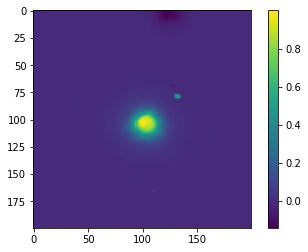

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

data=fits.getdata('data/sample_img_cropped.fits')
plt.imshow(data)
plt.colorbar()

Let's improve scaling of the image to show better contrast.

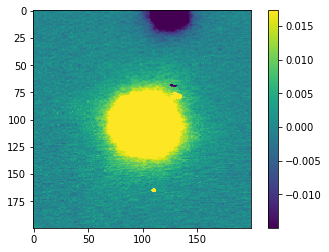

In [2]:
from astropy.visualization import ZScaleInterval

interval=ZScaleInterval()

vmin,vmax=interval.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)
plt.colorbar()

Ignore the black patch on top of the image and the small isolated bright point sources, such as on the bottom which are all image artifacts due to imperfection in the camera optics.

Let's write a convenience function to display the raw image, 2D line profile (horizontal) along centroid, and the 3D projection of the image. 

## psf

In [3]:
import numpy as np

def plot_psf(img_crop):
    vmin,vmax= ZScaleInterval().get_limits(img_crop)

    #raw image
    fig = plt.figure(figsize=(15,5))
    ax0 = fig.add_subplot(131)
    im=ax0.imshow(img_crop,vmin=vmin,vmax=vmax)
    fig.colorbar(im,ax=ax0)
    ax0.set_title('raw image')
    
    #2D line profile
    xdim=img_crop.shape[0]/2 #xcenter
    xslice=img_crop[int(xdim),:] #cut along the xcenter
    ax1 = fig.add_subplot(132)
    ax1.plot(xslice)
    ax1.set_title('2D line profile')
    #
    ax2 = fig.add_subplot(133, projection='3d')
    #ax = plt.gca(projection='3d')
    xx,yy=np.mgrid[0:img_crop.shape[0],0:img_crop.shape[1]]

    ax2.plot_surface(X=xx, Y=yy, Z=img_crop[yy,xx])
    ax2.set_title('3D surface profile')

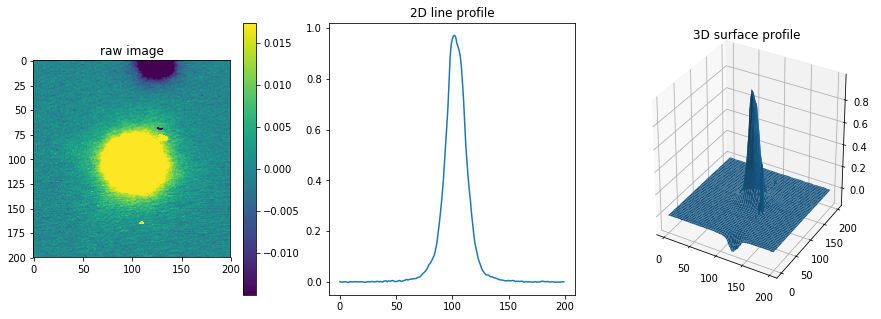

In [4]:
from mpl_toolkits.mplot3d import Axes3D

plot_psf(data)

My first impression is that this psf is far from being a gaussian. The (normalized) line profile has a narrow peak which is also shown in the 3D projection. 

## 1D psf modeling

Let's begin to 1D modelling of the psf shown above. For this purpose, `astropy` and `scipy` have available modules for this purpose. 

Our 1D gaussian model for the PSF is simply:
$$
PSF=A*\exp\Big(-{\frac{(x-\mu_x)^2}{2\sigma^2_x}}\Big)+\epsilon
$$

To do this, we will first apply convolution using the `gaussian_filter` with standard deviation $\sigma$ equal to the original psf to "smoothen" the psf without significantly changing the inherent information in the image. The sigma can be derived from the full-width at half maximum (FWHM) of the psf which we will estimate as follows. 

[80, 120, 0.4, 0.6]

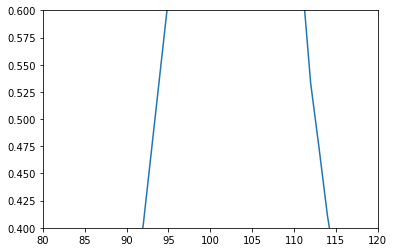

In [5]:
xdim=data.shape[0]/2 #xcenter
xslice=data[int(xdim),:] #cut along the xcenter
plt.plot(xslice)
plt.axis([80, 120, 0.4, 0.6])

So I estimate the fwhm is 112-92=20 pixels. Using the convenience function to convert fwhm to sigma:

In [6]:
def fwhm_to_sigma(fwhm):
    return fwhm/ (2*np.sqrt(2*np.log(2)))

def sigma_to_fwhm(sigma):
    return sigma * (2*np.sqrt(2*np.log(2)))

In [7]:
sigma_estimate=fwhm_to_sigma(20)
sigma_estimate

8.4932180028801909

We wil use this $\sigma$ later for convolving the image before fitting.

In [8]:
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter

def gauss1D(x, *params):
    '''
    1D gaussian model
    '''
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

def model_gaussian(image_crop, convolve=False, sigma_estimate = 8.0,
                   verbose=False, show_fit=False, return_fwhm=False):
    #colvolve image
    if convolve==True:
        image_crop = gaussian_filter(image_crop,sigma=sigma_estimate)
    #normalize image
    image_crop /= np.max(image_crop)
    # https://python4astronomers.github.io/fitting/sherpa.html
    i,j = np.unravel_index(image_crop.argmax(), image_crop.shape) #take x,y max
    peak_x=image_crop[i,:]
    peak_y=image_crop[:,j]
    
    #estimate mean and standard deviation
    ydata = (peak_x+peak_y)/2.0
    #ydata /= np.max(ydata)
    xdata = np.array(range(len(ydata)))
    xmean = len(xdata)/2.0
    sigma = np.std(ydata) #or sigma_estimate
    amp = np.max(ydata)
    eps = np.median(ydata)
    
    #fitting: optimize params and covariance
    popt, pcov = curve_fit(gauss1D, xdata, ydata, p0 = [amp, xmean, sigma, eps])

    if show_fit == True:
        plt.plot(xdata,gauss1D(xdata, *popt), label='Gaussian fit')
        plt.plot(xdata,ydata,'o',label='data',alpha=0.5)
        plt.legend()
    if verbose==True:
        print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(popt[0],popt[1], popt[2], popt[3]))

    if return_fwhm==True:
        fwhm=sigma_to_fwhm(popt[2])
        return popt, fwhm
    return popt, pcov

A: 0.984474473496
mu: 103.552523303
sigma= 12.7318428736
eps: 0.00487176753858


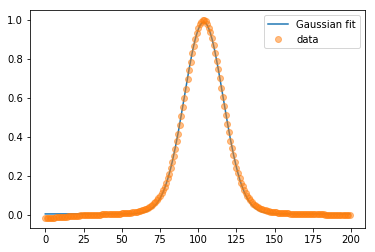

In [9]:
popt, pcov=model_gaussian(data, verbose=True, convolve=True, 
                          sigma_estimate=8.5, show_fit=True);

We got good results; the model fits the (smoothed) data. There are two tricks we did in our modeling. First, we smoothed the image (using a gaussian filter) to approximate our data with a gaussian model. Second, we normalized the image such that the amplitude parameter in our model is almost always close to 1. This is similar to knowing that the centroid of our point source is near the center of the image. As a result, we have better initial guesses which yielded good results.

As an add-on, we get also the covariance of our data. The covariance shows the relationship between the 4 model parameters specified above.

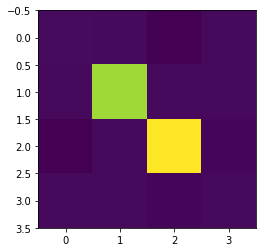

In [10]:
plt.imshow(pcov)

## 2D psf modeling
Our 2D gaussian model for the PSF is given by:
$$
PSF=A*\exp\Big(-{\frac{(x-\mu_x)^2}{2\sigma^2_x}}+{\frac{(y-\mu_y)^2}{2\sigma^2_y}}\Big)+\epsilon
$$
For our model implementation, we will use the results of the 1D gaussian model as initial estimate of our gaussian 2D model. We will also use convenience function to display the results.

In [31]:
import warnings
from photutils import centroid_com, centroid_1dg, centroid_2dg
from astropy.modeling import models, fitting

def model_gaussian2D(img_crop, verbose=False, fwhm=8., return_fwhm=False):
    sigma= fwhm_to_sigma(fwhm)
    try:
        #get 1D fit results
        result_1Dfit = model_gaussian(img_crop)
        amp, mu, sigma, eps = result_1Dfit
        #initialize model
        g_init = models.Gaussian2D(amplitude=amp,x_mean=mu, y_mean=mu, 
                                   x_stddev=sigma, y_stddev=sigma)
    except:
        sigma= fwhm_to_sigma(fwhm)
        #if 1D fitting fails due to wrong initial centroiding
        x_mean, y_mean = img_crop.shape[0]/2, img_crop.shape[1]/2 
        #initialize model using default values
        g_init = models.Gaussian2D(amplitude=1,x_mean=x_mean, y_mean=y_mean, 
                                   x_stddev=sigma, y_stddev=sigma)

    #fit model
    fit_g = fitting.LevMarLSQFitter()

    #normalize image before fitting
    img_crop_norm =img_crop/np.max(img_crop)

    x,y=range(img_crop.shape[0]),range(img_crop.shape[1])
    with warnings.catch_warnings():
        # Ignore model linearity warning from the fitter
        warnings.simplefilter('ignore')
        g = fit_g(g_init, x, y, (img_crop_norm[y,x]))

    if verbose==True:
        print(g.param_names,g.param_sets)
        
    if return_fwhm==True:
        fwhm_mean = sigma_to_fwhm(np.abs((g.x_stddev.value+g.y_stddev.value)/2))
        return g, fwhm_mean	

    return g

def get_crop(image, centroid, box_size):
    '''
    simple cropping tool
    '''
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),
                               int(x-(box_size/2)):int(x+(box_size/2))])
    return image_crop

def get_centroid(image, method='com'):
    '''
    centroid_com(): Calculates the object “center of mass” from 2D image moments.
    centroid_1dg(): Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
    centroid_2dg(): Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.
    Default is com.
    '''
    if method=='com':
        x, y = centroid_com(image)
        return (x,y)

    elif method=='1d_gaussian':
        x, y = centroid_1dg(image)
        return (x,y)
    elif method=='2d_gaussian':
        #bug: takes too much time; fit may be unsuccessful
        x, y = centroid_2dg(image)
        return (x,y)
    else:
        print('invalid centroiding algorithm')

def show_fit_2D(sample_img, centroid, sigma_estimate=8., boxsize=40, 
                show_image=True, convolve=False, recenter=False, show_3D=False):
    if convolve==True:
        sample_img = gaussian_filter(sample_img, sigma=sigma_estimate)

    if recenter == True:
        #crop a bigger box first
        img_crop = get_crop(sample_img, centroid, box_size=boxsize)
        #############RECENTROID#############
        xy_new = get_centroid(img_crop, method='1d_gaussian')
        
        #------------RE-CROP with smaller box------------#
        img_crop = get_crop(img_crop, xy_new, box_size=boxsize)
    else:
        img_crop = get_crop(sample_img,centroid,box_size=boxsize)

    fig = plt.figure(figsize=(15,5))

    #define and fit model
    g = model_gaussian2D(img_crop)
    xx,yy=np.mgrid[0:img_crop.shape[0],0:img_crop.shape[1]]

    if show_image==True:
        #data
        ax1 = plt.subplot(1,3,1)
        ax1.imshow(img_crop, origin='lower', interpolation='nearest')
        ax1.contour(img_crop, colors='w')
        ax1.plot(img_crop.shape[0]/2,img_crop.shape[1]/2, 'r+', markersize=20)
        ax1.set_title('data')
        ax1.set_xlabel('{0:.1f},  {1:.1f}'.format(centroid[0],centroid[1])) #centroid x,y
        #model
        ax2 = plt.subplot(1,3,2)
        ax2.imshow(g(yy,xx), origin='lower', interpolation='nearest')
        ax2.contour(img_crop, colors='w')
        ax2.plot(img_crop.shape[0]/2,img_crop.shape[1]/2, 'r+', markersize=20)
        ax2.set_title('model')
        ax2.set_xlabel(g.param_sets[1:3].flatten()) #centroid x,y
        #residual
        ax3 = plt.subplot(1,3,3)
        ax3.imshow(img_crop-g(yy,xx), origin='lower', interpolation='nearest')
        ax3.plot(img_crop.shape[0]/2,img_crop.shape[1]/2, 'r+', markersize=20)
        ax3.set_title('residual')

        '''
        Take note of the 3D syntax: g(yy,xx)[yy,xx]
        '''
        if show_3D==True:
            fig = plt.figure(figsize=(15,5))
            #data
            img_crop_norm = img_crop/np.max(img_crop)
            ax1 = fig.add_subplot(131, projection='3d')
            ax1.plot_surface(X=xx, Y=yy, Z=img_crop_norm[yy,xx])
            ax1.set_title('data (rescaled)')
            #model
            ax2 = fig.add_subplot(132, projection='3d')
            ax2.plot_surface(X=xx, Y=yy, Z=g(yy,xx)[yy,xx])
            ax2.set_title('model')
            #residual
            ax3 = fig.add_subplot(133, projection='3d')
            ax3.plot_surface(X=xx, Y=yy, Z=(img_crop-g(yy,xx)[yy,xx]))
            ax3.set_title('residual')
    return g

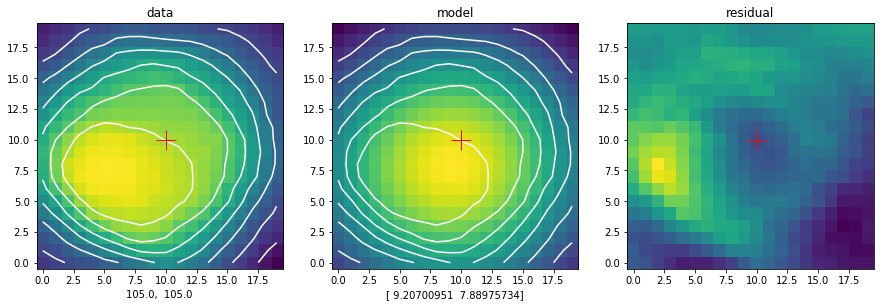

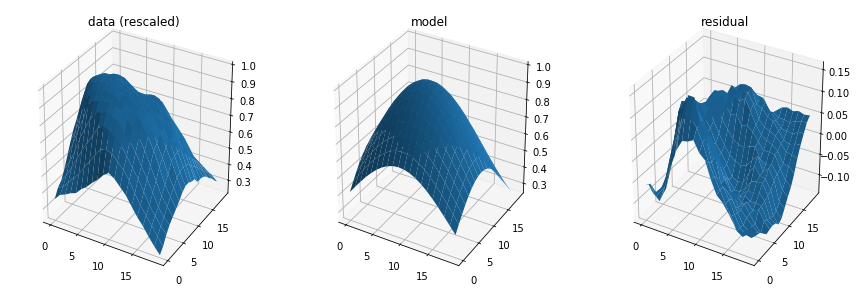

In [43]:
#get x-a and y-centroids
xycen=data.shape[0]/2+5,data.shape[1]/2+5

g=show_fit_2D(data, xycen, show_image=True, show_3D=True, 
            convolve=False, sigma_estimate=8.5, boxsize=20, recenter=False);